In [17]:
# !pip install umap
# !pip install neupy

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# # Import for GNG clustering
# try:
import neupy
GNG_AVAILABLE = True
# except ImportError:
#     print("neupy not available. Install with: pip install neupy")
#     GNG_AVAILABLE = False

In [25]:
df = pd.read_csv('static_all_gauges.csv')

In [26]:
# Data preprocessing for clustering
print(f"Original dataset shape: {df.shape}")
print(f"Missing values per column:\n{df.isnull().sum().sum()}")

# Select only numerical columns for clustering
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Number of numerical columns: {len(numerical_cols)}")

# Remove gauge_id as it's an identifier
if 'gauge_id' in numerical_cols:
    numerical_cols.remove('gauge_id')

# Create numerical dataset
df_numeric = df[numerical_cols].copy()
print(f"Numerical dataset shape: {df_numeric.shape}")

Original dataset shape: (242, 211)
Missing values per column:
3463
Number of numerical columns: 198
Numerical dataset shape: (242, 197)


In [27]:
# Handle missing values
print(f"Missing values before cleaning: {df_numeric.isnull().sum().sum()}")

# Fill missing values with median for numerical columns
df_numeric = df_numeric.fillna(df_numeric.median())
print(f"Missing values after cleaning: {df_numeric.isnull().sum().sum()}")

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
print(f"Scaled dataset shape: {df_scaled.shape}")

Missing values before cleaning: 3196
Missing values after cleaning: 0
Scaled dataset shape: (242, 197)


In [43]:
# Apply UMAP for dimensionality reduction
print("Applying UMAP dimensionality reduction...")

# UMAP with different components for visualization and clustering
umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embedding_2d = umap_2d.fit_transform(df_scaled)

# UMAP with higher dimensions for better clustering
umap_nd = umap.UMAP(n_components=17, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embedding_nd = umap_nd.fit_transform(df_scaled)

print(f"UMAP 2D embedding shape: {umap_embedding_2d.shape}")
print(f"UMAP {umap_nd.n_components}D embedding shape: {umap_embedding_nd.shape}")

Applying UMAP dimensionality reduction...
UMAP 2D embedding shape: (242, 2)
UMAP 17D embedding shape: (242, 17)


In [44]:
# Determine optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 20)

print("Finding optimal number of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(umap_embedding_nd)
    silhouette_avg = silhouette_score(umap_embedding_nd, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}, silhouette score: {silhouette_avg:.3f}")

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

Finding optimal number of clusters...
For k=2, silhouette score: 0.493
For k=3, silhouette score: 0.524
For k=4, silhouette score: 0.514
For k=5, silhouette score: 0.483
For k=6, silhouette score: 0.491
For k=7, silhouette score: 0.497
For k=8, silhouette score: 0.496
For k=9, silhouette score: 0.461
For k=10, silhouette score: 0.474
For k=11, silhouette score: 0.475
For k=12, silhouette score: 0.460
For k=13, silhouette score: 0.459
For k=14, silhouette score: 0.454
For k=15, silhouette score: 0.453
For k=16, silhouette score: 0.467
For k=17, silhouette score: 0.451
For k=18, silhouette score: 0.455
For k=19, silhouette score: 0.464

Optimal number of clusters: 3


In [45]:
# Apply K-means clustering with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(umap_embedding_nd)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

print(f"Cluster distribution:")
print(df_clustered['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    83
1    94
2    65
Name: count, dtype: int64


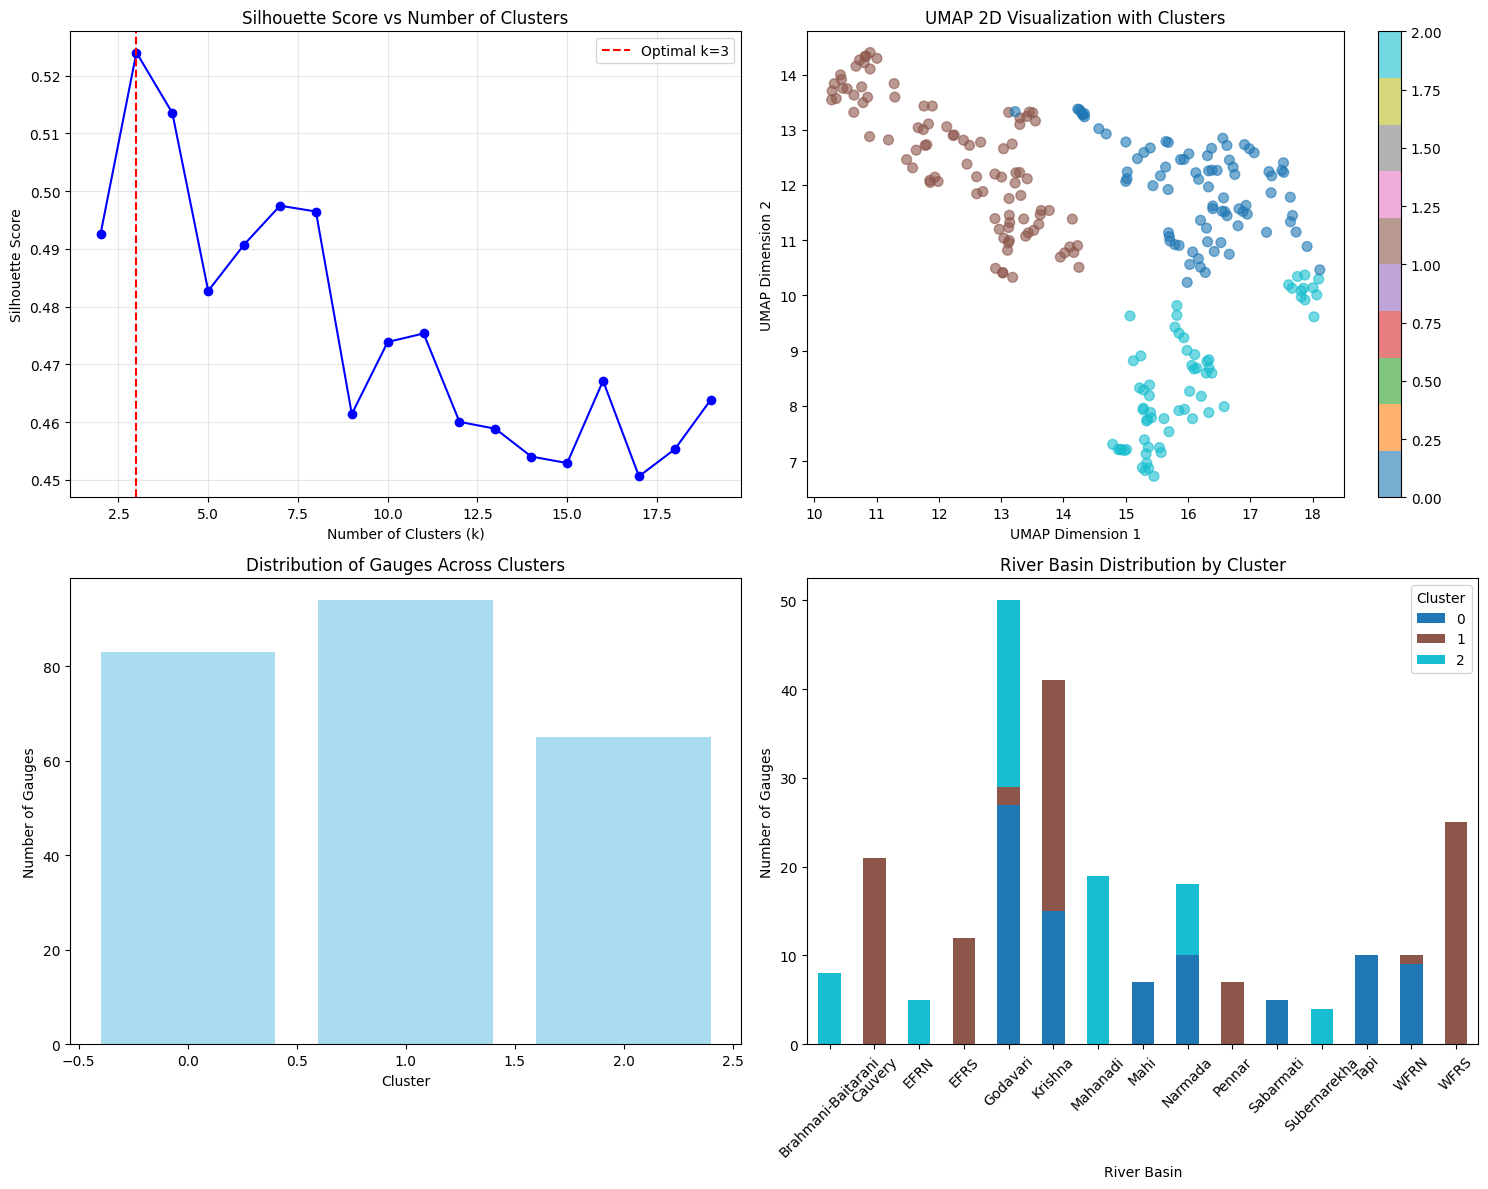

In [46]:
# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Silhouette scores
axes[0, 0].plot(k_range, silhouette_scores, 'bo-')
axes[0, 0].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: UMAP 2D visualization with clusters
scatter = axes[0, 1].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                            c=cluster_labels, cmap='tab10', alpha=0.6, s=50)
axes[0, 1].set_xlabel('UMAP Dimension 1')
axes[0, 1].set_ylabel('UMAP Dimension 2')
axes[0, 1].set_title('UMAP 2D Visualization with Clusters')
plt.colorbar(scatter, ax=axes[0, 1])

# Plot 3: Cluster sizes
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
axes[1, 0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.7)
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Gauges')
axes[1, 0].set_title('Distribution of Gauges Across Clusters')

# Plot 4: River basin distribution by cluster
basin_cluster = pd.crosstab(df_clustered['river_basin'], df_clustered['cluster'])
basin_cluster.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='tab10')
axes[1, 1].set_xlabel('River Basin')
axes[1, 1].set_ylabel('Number of Gauges')
axes[1, 1].set_title('River Basin Distribution by Cluster')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title='Cluster')

plt.tight_layout()
plt.show()

In [32]:
# Analyze cluster characteristics
print("=== CLUSTER ANALYSIS ===\n")

# Select key features for cluster characterization
key_features = ['p_mean', 'tmax_mean', 'elev_mean', 'slope_mean', 'cwc_area', 
                'pop_density_2020', 'crops_frac', 'trees_frac', 'soil_depth']

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)}):")
    print(f"River basins: {cluster_data['river_basin'].value_counts().to_dict()}")
    
    print("Key characteristics:")
    for feature in key_features:
        if feature in df_clustered.columns:
            mean_val = cluster_data[feature].mean()
            print(f"  {feature}: {mean_val:.2f}")
    print("-" * 50)

=== CLUSTER ANALYSIS ===

CLUSTER 0 (n=18):
River basins: {'Godavari': 7, 'Narmada': 6, 'Krishna': 4, 'Mahanadi': 1}
Key characteristics:
  p_mean: 2.87
  tmax_mean: 32.61
  elev_mean: 482.72
  slope_mean: 4.77
  cwc_area: 128292.00
  pop_density_2020: 277.50
  crops_frac: 0.58
  trees_frac: 0.16
  soil_depth: 5.62
--------------------------------------------------
CLUSTER 1 (n=24):
River basins: {'Cauvery': 13, 'WFRS': 5, 'Krishna': 4, 'EFRS': 2}
Key characteristics:
  p_mean: 3.20
  tmax_mean: 30.01
  elev_mean: 780.63
  slope_mean: 12.14
  cwc_area: 12511.83
  pop_density_2020: 388.89
  crops_frac: 0.29
  trees_frac: 0.48
  soil_depth: 1.42
--------------------------------------------------
CLUSTER 2 (n=47):
River basins: {'Mahanadi': 17, 'Godavari': 13, 'Brahmani-Baitarani': 8, 'EFRN': 5, 'Subernarekha': 4}
Key characteristics:
  p_mean: 3.70
  tmax_mean: 32.18
  elev_mean: 462.50
  slope_mean: 7.90
  cwc_area: 11613.49
  pop_density_2020: 252.45
  crops_frac: 0.35
  trees_frac: 0.

In [33]:
# Save results
# df_clustered.to_csv('clustered_gauges.csv', index=False)
print("Clustered dataset saved as 'clustered_gauges.csv'")

# Create a summary of cluster centers in original feature space
cluster_centers_original = []
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_mask = cluster_labels == cluster_id
    cluster_center = df_numeric[cluster_mask].mean()
    cluster_centers_original.append(cluster_center)

cluster_centers_df = pd.DataFrame(cluster_centers_original, 
                                 index=[f'Cluster_{i}' for i in range(optimal_k)])
# cluster_centers_df.to_csv('cluster_centers.csv')
print("Cluster centers saved as 'cluster_centers.csv'")

Clustered dataset saved as 'clustered_gauges.csv'
Cluster centers saved as 'cluster_centers.csv'


# Growing Neural Gas (GNG) Clustering Analysis

GNG is an unsupervised neural network that can learn the topology of input data and automatically determine the number of clusters.

In [35]:
# Growing Neural Gas Clustering Implementation
from neupy import algorithms
if GNG_AVAILABLE:
    print("=== GROWING NEURAL GAS CLUSTERING ===\n")
    
    # Use UMAP embedding for GNG clustering
    print("Applying GNG clustering on UMAP embedding...")
    
    # Initialize GNG network
    gng = algorithms.GrowingNeuralGas(
        n_inputs=umap_embedding_nd.shape[1],
        n_start_nodes=2,
        max_nodes=20,  # Maximum number of nodes (clusters)
        step=0.1,
        neighbour_step=0.01,
        max_edge_age=50,
        max_epochs=100,
        min_distance_for_update=0.01,
        verbose=True
    )
    
    # Train GNG network
    gng.train(umap_embedding_nd, epochs=100)
    
    # Get cluster assignments
    gng_labels = []
    for point in umap_embedding_nd:
        # Find closest node
        distances = [np.linalg.norm(point - node) for node in gng.graph.nodes]
        closest_node = np.argmin(distances)
        gng_labels.append(closest_node)
    
    gng_labels = np.array(gng_labels)
    n_gng_clusters = len(np.unique(gng_labels))
    
    print(f"GNG found {n_gng_clusters} clusters")
    print(f"GNG cluster distribution:")
    unique, counts = np.unique(gng_labels, return_counts=True)
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} points")
    
    # Calculate silhouette score for GNG
    if n_gng_clusters > 1:
        gng_silhouette = silhouette_score(umap_embedding_nd, gng_labels)
        print(f"GNG silhouette score: {gng_silhouette:.3f}")
    else:
        gng_silhouette = -1
        print("GNG silhouette score: N/A (only 1 cluster)")
        
else:
    print("GNG clustering not available. Install neupy package.")
    gng_labels = None
    n_gng_clusters = 0
    gng_silhouette = -1

ImportError: cannot import name 'MutableMapping' from 'collections' (C:\Users\AKSHAT SHAW\anaconda3\Lib\collections\__init__.py)

In [ ]:
# Compare K-means vs GNG clustering results
if GNG_AVAILABLE and gng_labels is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: K-means clustering on UMAP 2D
    scatter1 = axes[0, 0].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                                 c=cluster_labels, cmap='tab10', alpha=0.6, s=50)
    axes[0, 0].set_xlabel('UMAP Dimension 1')
    axes[0, 0].set_ylabel('UMAP Dimension 2')
    axes[0, 0].set_title(f'K-means Clustering (k={optimal_k})\nSilhouette: {max(silhouette_scores):.3f}')
    plt.colorbar(scatter1, ax=axes[0, 0])
    
    # Plot 2: GNG clustering on UMAP 2D
    scatter2 = axes[0, 1].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                                 c=gng_labels, cmap='tab10', alpha=0.6, s=50)
    axes[0, 1].set_xlabel('UMAP Dimension 1')
    axes[0, 1].set_ylabel('UMAP Dimension 2')
    axes[0, 1].set_title(f'GNG Clustering (n={n_gng_clusters})\nSilhouette: {gng_silhouette:.3f}')
    plt.colorbar(scatter2, ax=axes[0, 1])
    
    # Plot 3: Comparison of cluster sizes
    kmeans_counts = pd.Series(cluster_labels).value_counts().sort_index()
    gng_counts = pd.Series(gng_labels).value_counts().sort_index()
    
    x_pos = np.arange(max(len(kmeans_counts), len(gng_counts)))
    width = 0.35
    
    axes[0, 2].bar(x_pos - width/2, kmeans_counts.reindex(x_pos, fill_value=0), 
                   width, label='K-means', alpha=0.7)
    axes[0, 2].bar(x_pos + width/2, gng_counts.reindex(x_pos, fill_value=0), 
                   width, label='GNG', alpha=0.7)
    axes[0, 2].set_xlabel('Cluster ID')
    axes[0, 2].set_ylabel('Number of Points')
    axes[0, 2].set_title('Cluster Size Comparison')
    axes[0, 2].legend()
    
    # Plot 4: River basin distribution - K-means
    df_kmeans = df.copy()
    df_kmeans['cluster'] = cluster_labels
    basin_kmeans = pd.crosstab(df_kmeans['river_basin'], df_kmeans['cluster'])
    basin_kmeans.plot(kind='bar', stacked=True, ax=axes[1, 0], colormap='tab10')
    axes[1, 0].set_xlabel('River Basin')
    axes[1, 0].set_ylabel('Number of Gauges')
    axes[1, 0].set_title('K-means: River Basin Distribution')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend(title='K-means Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 5: River basin distribution - GNG
    df_gng = df.copy()
    df_gng['cluster'] = gng_labels
    basin_gng = pd.crosstab(df_gng['river_basin'], df_gng['cluster'])
    basin_gng.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='tab10')
    axes[1, 1].set_xlabel('River Basin')
    axes[1, 1].set_ylabel('Number of Gauges')
    axes[1, 1].set_title('GNG: River Basin Distribution')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend(title='GNG Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 6: Silhouette comparison
    methods = ['K-means', 'GNG']
    scores = [max(silhouette_scores), gng_silhouette if gng_silhouette > 0 else 0]
    colors = ['skyblue', 'lightcoral']
    
    bars = axes[1, 2].bar(methods, scores, color=colors, alpha=0.7)
    axes[1, 2].set_ylabel('Silhouette Score')
    axes[1, 2].set_title('Clustering Method Comparison')
    axes[1, 2].set_ylim(0, max(scores) * 1.1)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Skipping GNG comparison plots - GNG not available")

In [ ]:
# Analyze GNG cluster characteristics
if GNG_AVAILABLE and gng_labels is not None:
    print("=== GNG CLUSTER ANALYSIS ===\n")
    
    df_gng_clustered = df.copy()
    df_gng_clustered['gng_cluster'] = gng_labels
    
    # Select key features for cluster characterization
    key_features = ['p_mean', 'tmax_mean', 'elev_mean', 'slope_mean', 'cwc_area', 
                    'pop_density_2020', 'crops_frac', 'trees_frac', 'soil_depth']
    
    for cluster_id in sorted(df_gng_clustered['gng_cluster'].unique()):
        cluster_data = df_gng_clustered[df_gng_clustered['gng_cluster'] == cluster_id]
        print(f"GNG CLUSTER {cluster_id} (n={len(cluster_data)}):")
        print(f"River basins: {cluster_data['river_basin'].value_counts().to_dict()}")
        
        print("Key characteristics:")
        for feature in key_features:
            if feature in df_gng_clustered.columns:
                mean_val = cluster_data[feature].mean()
                print(f"  {feature}: {mean_val:.2f}")
        print("-" * 50)
    
    # Compare clustering methods summary
    print("\n=== CLUSTERING METHODS SUMMARY ===")
    print(f"K-means:")
    print(f"  - Number of clusters: {optimal_k}")
    print(f"  - Silhouette score: {max(silhouette_scores):.3f}")
    print(f"  - Method: Centroid-based, requires pre-specified k")
    
    print(f"\nGNG:")
    print(f"  - Number of clusters: {n_gng_clusters}")
    print(f"  - Silhouette score: {gng_silhouette:.3f}")
    print(f"  - Method: Topology-preserving, adaptive cluster number")
    
    # Save GNG results
    df_gng_clustered.to_csv('gng_clustered_gauges.csv', index=False)
    print(f"\nGNG clustered dataset saved as 'gng_clustered_gauges.csv'")
    
else:
    print("GNG analysis not available")

In [ ]:
# Alternative GNG implementation using sklearn-compatible approach
# (In case neupy is not available)

class SimpleGNG:
    """Simplified Growing Neural Gas implementation"""
    
    def __init__(self, max_nodes=20, max_epochs=100):
        self.max_nodes = max_nodes
        self.max_epochs = max_epochs
        self.nodes = []
        self.edges = []
        
    def fit(self, X):
        """Fit GNG to data"""
        n_samples, n_features = X.shape
        
        # Initialize with two random nodes
        self.nodes = [X[np.random.randint(0, n_samples)].copy() for _ in range(2)]
        self.edges = []
        
        for epoch in range(self.max_epochs):
            # Select random input
            xi = X[np.random.randint(0, n_samples)]
            
            # Find two closest nodes
            distances = [np.linalg.norm(xi - node) for node in self.nodes]
            sorted_indices = np.argsort(distances)
            winner_idx = sorted_indices[0]
            second_idx = sorted_indices[1]
            
            # Move winner towards input
            self.nodes[winner_idx] += 0.1 * (xi - self.nodes[winner_idx])
            
            # Move neighbors of winner
            for i, node in enumerate(self.nodes):
                if i != winner_idx and self._are_connected(winner_idx, i):
                    self.nodes[i] += 0.01 * (xi - self.nodes[i])
            
            # Add edge between winner and second closest
            self._add_edge(winner_idx, second_idx)
            
            # Add new node periodically if not at max
            if len(self.nodes) < self.max_nodes and epoch % 10 == 0:
                self._add_node()
        
        return self
    
    def predict(self, X):
        """Assign cluster labels"""
        labels = []
        for xi in X:
            distances = [np.linalg.norm(xi - node) for node in self.nodes]
            labels.append(np.argmin(distances))
        return np.array(labels)
    
    def _are_connected(self, i, j):
        """Check if two nodes are connected"""
        return (i, j) in self.edges or (j, i) in self.edges
    
    def _add_edge(self, i, j):
        """Add edge between nodes"""
        if not self._are_connected(i, j):
            self.edges.append((i, j))
    
    def _add_node(self):
        """Add new node at edge with highest error"""
        if len(self.nodes) >= 2:
            # Simple strategy: add node between two existing nodes
            i, j = np.random.choice(len(self.nodes), 2, replace=False)
            new_node = (self.nodes[i] + self.nodes[j]) / 2
            self.nodes.append(new_node)

# Alternative GNG clustering if neupy not available
if not GNG_AVAILABLE:
    print("=== ALTERNATIVE GNG IMPLEMENTATION ===\n")
    
    # Use simple GNG implementation
    simple_gng = SimpleGNG(max_nodes=15, max_epochs=200)
    simple_gng.fit(umap_embedding_nd)
    simple_gng_labels = simple_gng.predict(umap_embedding_nd)
    
    n_simple_gng_clusters = len(np.unique(simple_gng_labels))
    print(f"Simple GNG found {n_simple_gng_clusters} clusters")
    
    # Calculate silhouette score
    if n_simple_gng_clusters > 1:
        simple_gng_silhouette = silhouette_score(umap_embedding_nd, simple_gng_labels)
        print(f"Simple GNG silhouette score: {simple_gng_silhouette:.3f}")
    else:
        simple_gng_silhouette = -1
    
    # Visualize simple GNG results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Simple GNG clustering
    scatter1 = axes[0].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                              c=simple_gng_labels, cmap='tab10', alpha=0.6, s=50)
    axes[0].set_xlabel('UMAP Dimension 1')
    axes[0].set_ylabel('UMAP Dimension 2')
    axes[0].set_title(f'Simple GNG Clustering (n={n_simple_gng_clusters})')
    plt.colorbar(scatter1, ax=axes[0])
    
    # Comparison with K-means
    scatter2 = axes[1].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                              c=cluster_labels, cmap='tab10', alpha=0.6, s=50)
    axes[1].set_xlabel('UMAP Dimension 1')
    axes[1].set_ylabel('UMAP Dimension 2')
    axes[1].set_title(f'K-means Clustering (k={optimal_k})')
    plt.colorbar(scatter2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
    
    # Save simple GNG results
    df_simple_gng = df.copy()
    df_simple_gng['simple_gng_cluster'] = simple_gng_labels
    df_simple_gng.to_csv('simple_gng_clustered_gauges.csv', index=False)
    print("Simple GNG clustered dataset saved as 'simple_gng_clustered_gauges.csv'")